In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import classification_report
import pydotplus  # for tree visualization
from IPython.display import Image 
import math

%matplotlib inline
plt.style.use('seaborn')

## Decision Trees

Decision trees are extremely intuitive ways to classify or label objects: you simply ask a series of questions designed to zero in on the classification. For example, if you wanted to build a decision tree to classify an animal you come across while on a hike, you might construct the one shown here:

<img src="images/decision-tree.png"/>

The binary splitting makes this algorithm very efficient. In a well-constructed tree, each question will cut the number of options by approximately half, very quickly narrowing the options even among a large number of classes.

The trick, of course, is in deciding which questions to ask at each step!

In machine learning implementations of decision trees, the questions generally take the form of axis-aligned splits in the data: that is, each node in the tree splits the data into two groups using a cutoff value within one of the features.
Let's now look at an example of this.

Let's create some random data to try out a decision tree.

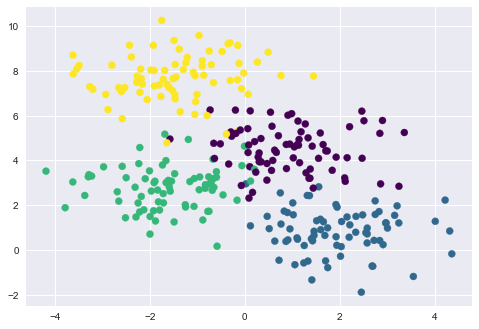

In [2]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='viridis');

A simple decision tree built on this data will iteratively split the data along one or the other axis according to some quantitative criterion, and at each level assign the label of the new region according to a majority vote of points within it.


We can use scikit-learn to create a decision tree as follows

In [3]:
from sklearn.tree import DecisionTreeClassifier
tree_model = DecisionTreeClassifier(max_depth=10, random_state=0)
tree_model.fit(X, y)

DecisionTreeClassifier(max_depth=10, random_state=0)

In [4]:
y_pred = tree_model.predict(X)
metrics.confusion_matrix(y, y_pred)

array([[75,  0,  0,  0],
       [ 0, 75,  0,  0],
       [ 0,  0, 75,  0],
       [ 0,  0,  0, 75]])

Something is fishy!  How can our classifier do so good?!

In [5]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        75
           1       1.00      1.00      1.00        75
           2       1.00      1.00      1.00        75
           3       1.00      1.00      1.00        75

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



In [6]:
# Let's look at some of the predictions
print(y_pred[:5]) 

[1 3 0 3 1]


In [7]:
print(tree_model.predict_proba(X[:5]))

[[0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]


These just look too good for a machine learning classifier.  Confirming fishiness!

Let's visualize what kind of classifier we have built.

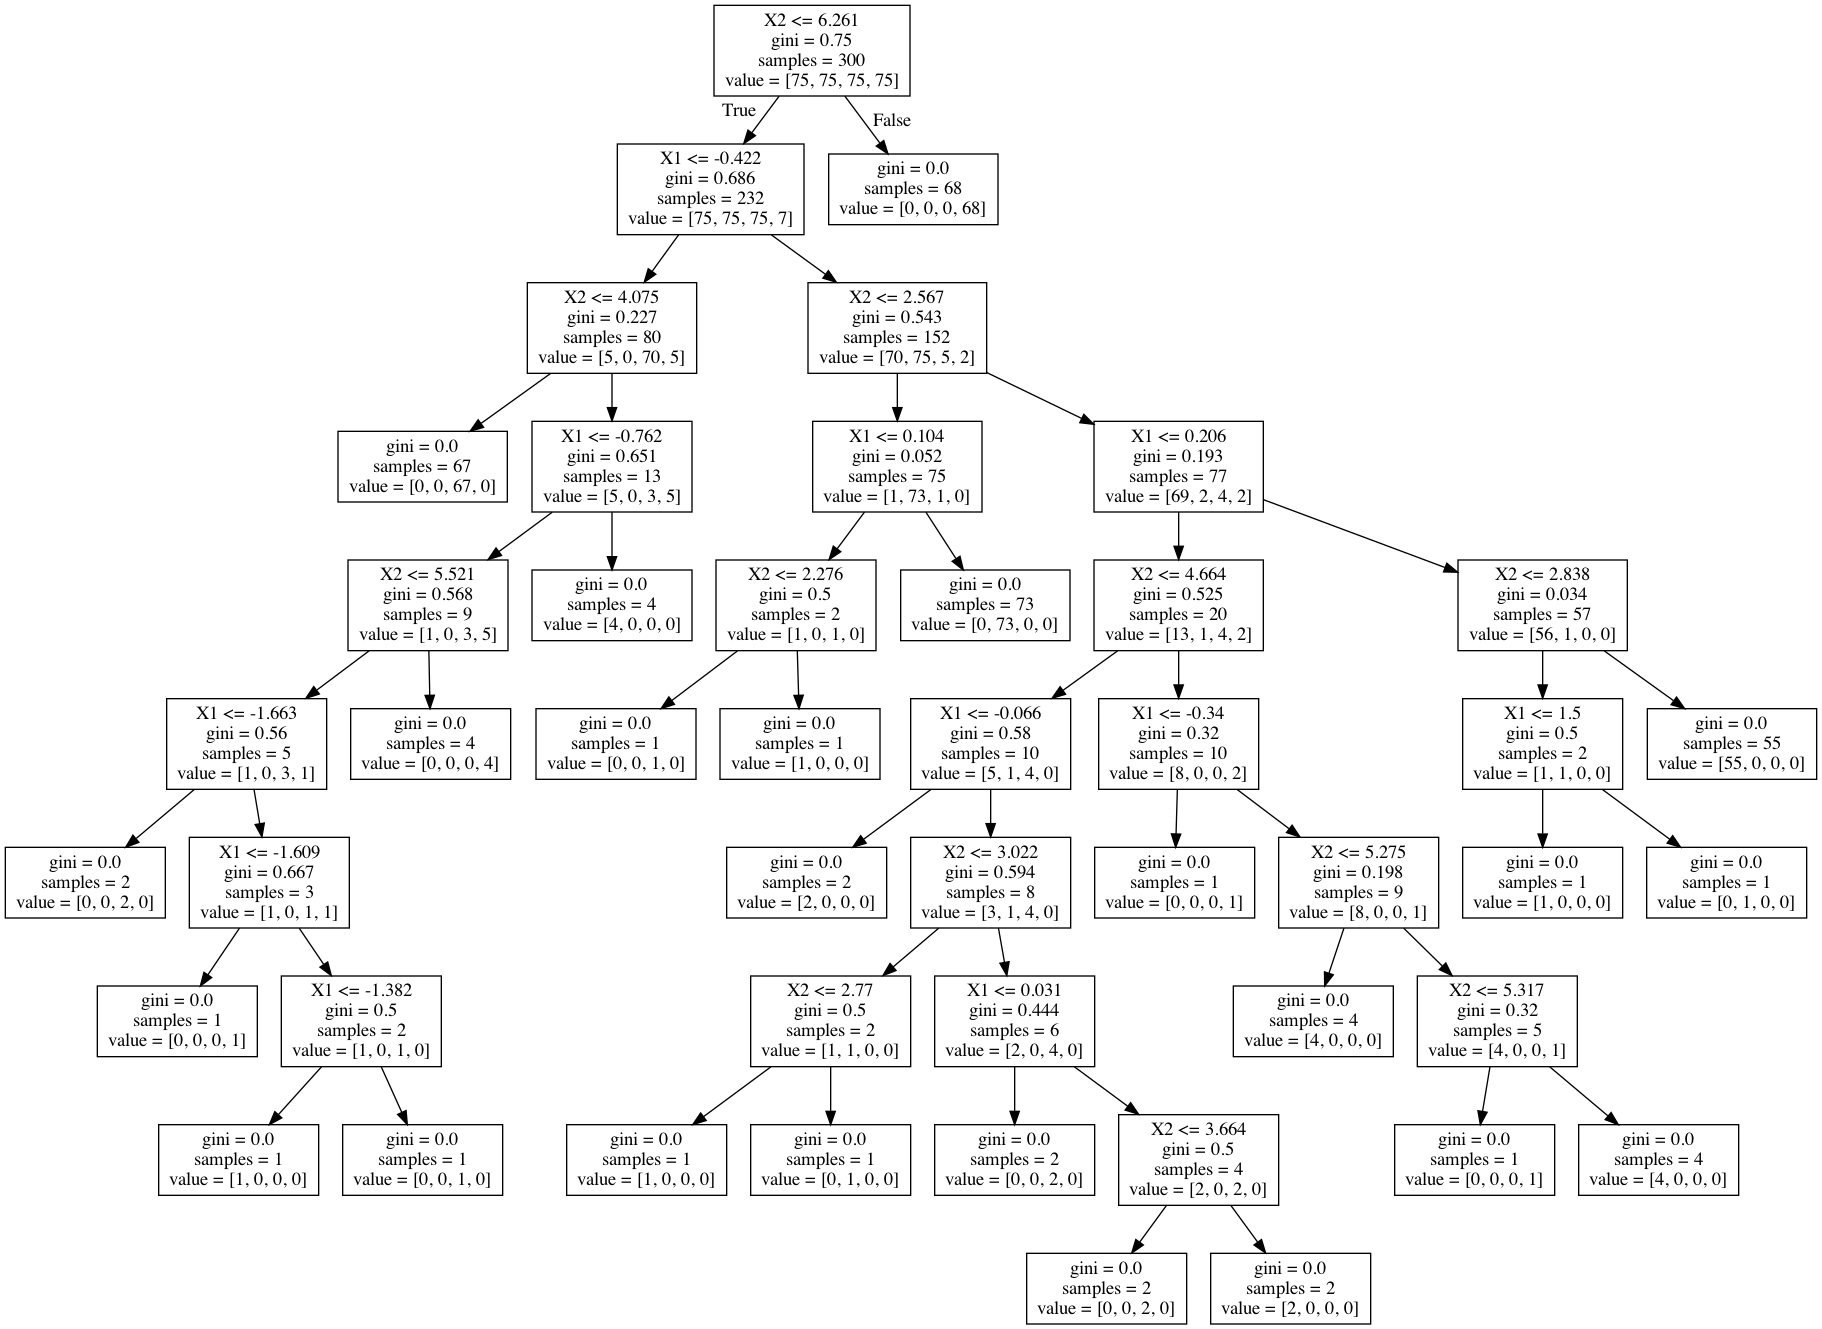

In [8]:
# Create DOT data
from sklearn import tree

dot_data = tree.export_graphviz(tree_model, 
                                out_file=None, 
                                feature_names=['X1', 'X2'])

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

## Decision Trees and Overfitting

How good our tree classifier seems less a result of the true, intrinsic data distribution, and more a result of the particular sampling or noise properties of the data.  We are __overfitting__ our training model to the particular data set.  We have built a low "bias" but high "variance" classifier.

Such overfitting turns out to be a general property of decision trees: it is very easy to go too deep in the tree, and thus to fit details of the particular data rather than the overall properties of the distributions they are drawn from.

When we create different trees with similar inputs, we may have trees that give very different classifications -- around input space that classification is less certain.  

**Intuition**: we would like to believe that by using information from multiple trees, we might come up with better (more generalizable) results.

# Ensembles of Estimators: Bagging and Random Forests

The notion that multiple overfitting estimators can be combined to reduce the effect of overfitting is what underlies an ensemble method called *bagging*.
Bagging makes use of an ensemble (a grab bag, perhaps) of parallel estimators, each of which overfits the data, and averages the results to find a better classification.
An ensemble of randomized decision trees is known as a *random forest*.

This type of bagging classification can be done manually using scikit-learn's ``BaggingClassifier`` meta-estimator, as shown here:

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

model = DecisionTreeClassifier()
bag = BaggingClassifier(model, n_estimators=100, max_samples=0.1,
                        random_state=1)

bag.fit(X, y)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=0.1,
                  n_estimators=100, random_state=1)

In [7]:
y_pred = bag.predict(X)
metrics.confusion_matrix(y, y_pred)

array([[70,  1,  3,  1],
       [ 3, 72,  0,  0],
       [ 4,  0, 71,  0],
       [ 2,  0,  1, 72]])

In [8]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91        75
           1       0.99      0.96      0.97        75
           2       0.95      0.95      0.95        75
           3       0.99      0.96      0.97        75

    accuracy                           0.95       300
   macro avg       0.95      0.95      0.95       300
weighted avg       0.95      0.95      0.95       300



In the above bagging example, we have randomized the data by fitting each estimator with a random subset of 10% of the training points.

In practice, decision trees are more effectively randomized by injecting some stochasticity in how the splits are chosen: this way all the data contributes to the fit each time, but the results of the fit still have the desired randomness.

For example, when determining which feature to split on, the randomized tree might select from among the top several features.

You can read more technical details about these randomization strategies in the <a href="http://scikit-learn.org/stable/modules/ensemble.html#forest" target="_blank">scikit-learn documentation and references within</a>.

In scikit-learn, such an optimized ensemble of randomized decision trees is implemented in the ``RandomForestClassifier`` estimator, which automatically takes care of all the randomization.
All you need to do is select a number of estimators, and it will very quickly (in parallel, if desired) fit the ensemble of trees:

In [9]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)

In [10]:
model.fit(X,y)
y_pred = model.predict(X)
metrics.confusion_matrix(y, y_pred)

array([[75,  0,  0,  0],
       [ 0, 75,  0,  0],
       [ 0,  0, 75,  0],
       [ 0,  0,  0, 75]])

## Random Forest Regression

Random forests can also be made to work in the case of regression (that is, continuous rather than categorical variables). The estimator to use for this is the ``RandomForestRegressor``, and the syntax is very similar to what we saw above.

Consider the following data, drawn from the combination of a fast and slow oscillation:

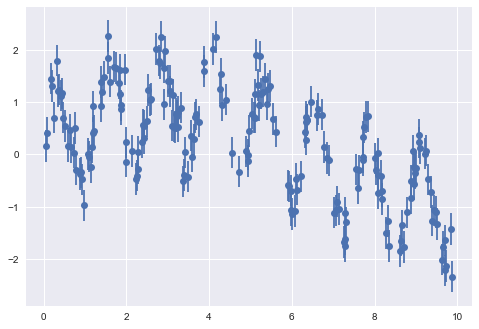

In [23]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.errorbar(x, y, 0.3, fmt='o');

In [24]:
x.shape

(200,)

In [13]:
x[:,None].shape

(200, 1)

Using the random forest regressor, we can find the best fit curve as follows:

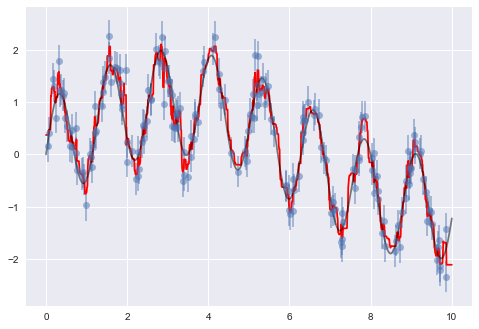

In [14]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(200)
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

Here the true model is shown in the smooth black curve, while the random forest model is shown by the jagged red curve.

As you can see, the nonparametric random forest model is flexible enough to fit the multiperiod data, without us needing to specifying a multiperiod model!

 ## Optical Character Recognition
 
 Let's look at a classic classification task using images: OCR.

In [15]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

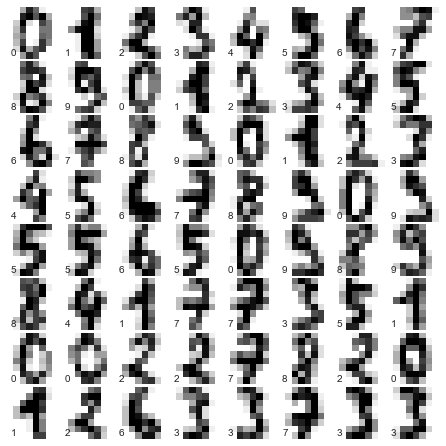

In [16]:
# set up the figure
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

We can quickly classify the digits using a random forest as follows:

In [17]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target)
model = RandomForestClassifier()
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

In [18]:
metrics.accuracy_score(ytest, ypred)

0.9711111111111111

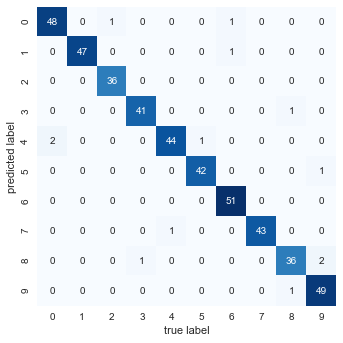

In [19]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='Blues')
plt.xlabel('true label')
plt.ylabel('predicted label');

We find that a simple, untuned random forest results in a very accurate classification of the digits data.

In any ensemble estimator, one free parameter you can tune is the number of estimators. Let's quickly look at how this affects the results in this case:

In [20]:
for n_estimators in [1, 5, 10, 50, 100, 150, 200, 250, 300, 500]:
    model = RandomForestClassifier(n_estimators=n_estimators)
    model.fit(Xtrain, ytrain)
    ypred = model.predict(Xtest)
    
    print(n_estimators, metrics.accuracy_score(ytest, ypred))

1 0.7222222222222222
5 0.8911111111111111
10 0.9288888888888889
50 0.9666666666666667
100 0.9755555555555555
150 0.9666666666666667
200 0.9711111111111111
250 0.9666666666666667
300 0.9755555555555555
500 0.9666666666666667


We see here that a larger ``n_estimators`` value, in this case, leads to a better accuracy on the test data.

Similarly, we could explore the effect of ``max_depth``, which controls how many splits each individual tree will have:

In [21]:
for max_depth in [1, 2, 4, 8, 16, 32, 64]:
    model = RandomForestClassifier(n_estimators=200,
                                   max_depth=max_depth)
    model.fit(Xtrain, ytrain)
    ypred = model.predict(Xtest)
    
    print(max_depth, metrics.accuracy_score(ytest, ypred))

1 0.6622222222222223
2 0.8155555555555556
4 0.9177777777777778
8 0.9644444444444444
16 0.9711111111111111
32 0.9711111111111111
64 0.9733333333333334


We see that in general, deeper trees lead to better results.

These parameters, ``n_estimators`` and ``max_depth``, are known as *hyperparameters* (parameters that control the model itself, rather than parameters fit by the model).